# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Load and process review dataset

In [2]:
products = pd.read_csv('amazon_baby_subset.csv')
products

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1
...,...,...,...,...
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1
53068,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1
53070,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1


Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)

Refer to Module 3 assignment for more details.

In [3]:
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

In [4]:
# import lib
import string
import re

'''
If your tool supports it, fill n/a values in the review column with empty strings. 
The n/a values indicate empty reviews. For instance, Pandas's the fillna() method 
lets you replace all N/A's in the review columns as follows:
'''
products = products.fillna({'review':''})  # fill in N/A's in the review column

In [5]:
# Function that cleans text by removing '\x0c' and '\n' characters
# as well as all non-alpha characters and finally converts everything
# to lower case

def clean_text(text):
    #translator = text.maketrans('', '', string.punctuation)
    #clean_text = text.translate(translator)
    # remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # remove all non-alpha characters and converts to lower case
    text = re.sub('[^a-zA-Z]+', ' ', text).lower()
    
    return text

products['review_clean'] = products['review'].apply(clean_text)
products

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,all of my kids have cried non stop when i trie...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,we wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,my daughter had her st baby over a year ago sh...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,one of baby s first and favorite books and it ...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,very cute interactive book my son loves this b...
...,...,...,...,...,...
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1,my infant goes to a really crappy daycare and ...
53068,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1,pretty please open and inspect these stickers ...
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1,great star product but an obvious knock off of...
53070,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1,when i received the item my initial thought wa...


In [6]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

products

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,all of my kids have cried non stop when i trie...,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,we wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,my daughter had her st baby over a year ago sh...,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,one of baby s first and favorite books and it ...,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,very cute interactive book my son loves this b...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1,my infant goes to a really crappy daycare and ...,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53068,"Mud Pie Milestone Stickers, Boy",Pretty please open and inspect these stickers ...,1,-1,pretty please open and inspect these stickers ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1,great star product but an obvious knock off of...,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
53070,Bouncy&reg; Inflatable Real Feel Hopping Cow,When I received the item my initial thought wa...,2,-1,when i received the item my initial thought wa...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `seed=2` so that everyone gets the same result.

**Note:** In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters**. Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on a validation set, while evaluation of selected model should always be on a test set.

In [7]:
train_data, validation_data = train_test_split(products, train_size=.8, random_state=2)

print('Training set   : %d data points' % len(train_data))
print('Validation set : %d data points' % len(validation_data))

Training set   : 42457 data points
Validation set : 10615 data points


## Convert SFrame to NumPy array

In [8]:
def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [9]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

C:\Users\vanch\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Building on logistic regression with no L2 penalty assignment

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [10]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    ## YOUR CODE HERE
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    ## YOUR CODE HERE
    predictions = 1 / (1 + np.exp(-score))
    
    return predictions

## Adding  L2 penalty

Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Note**: As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [11]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors,feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant: 
        ## YOUR CODE HERE
        derivative = derivative - (2 * l2_penalty * coefficient)
        
    return derivative

To verify the correctness of the gradient ascent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [12]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.  Fill in the code below to complete this modification.

In [13]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors,feature_matrix[:,j],coefficients[j],l2_penalty,is_intercept)
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] += step_size * derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print('iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp))
            
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [14]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29198.44383755
iteration   1: log likelihood of observed labels = -28978.29590657
iteration   2: log likelihood of observed labels = -28767.45180155
iteration   3: log likelihood of observed labels = -28565.13580625
iteration   4: log likelihood of observed labels = -28370.73765459
iteration   5: log likelihood of observed labels = -28183.75016359
iteration   6: log likelihood of observed labels = -28003.73398450
iteration   7: log likelihood of observed labels = -27830.29720462
iteration   8: log likelihood of observed labels = -27663.08330379
iteration   9: log likelihood of observed labels = -27501.76387217
iteration  10: log likelihood of observed labels = -27346.03404323
iteration  11: log likelihood of observed labels = -27195.60947061
iteration  12: log likelihood of observed labels = -27050.22418443
iteration  13: log likelihood of observed labels = -26909.62895549
iteration  14: log likelihood of observed labels = -26773.5899

In [15]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29198.44850264
iteration   1: log likelihood of observed labels = -28978.32303536
iteration   2: log likelihood of observed labels = -28767.51764891
iteration   3: log likelihood of observed labels = -28565.25529683
iteration   4: log likelihood of observed labels = -28370.92453035
iteration   5: log likelihood of observed labels = -28184.01709654
iteration   6: log likelihood of observed labels = -28004.09267015
iteration   7: log likelihood of observed labels = -27830.75844376
iteration   8: log likelihood of observed labels = -27663.65707606
iteration   9: log likelihood of observed labels = -27502.45940319
iteration  10: log likelihood of observed labels = -27346.85986603
iteration  11: log likelihood of observed labels = -27196.57348186
iteration  12: log likelihood of observed labels = -27051.33369583
iteration  13: log likelihood of observed labels = -26910.89074070
iteration  14: log likelihood of observed labels = -26775.0102

In [16]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29198.45550027
iteration   1: log likelihood of observed labels = -28978.36372579
iteration   2: log likelihood of observed labels = -28767.61640665
iteration   3: log likelihood of observed labels = -28565.43449668
iteration   4: log likelihood of observed labels = -28371.20476915
iteration   5: log likelihood of observed labels = -28184.41736280
iteration   6: log likelihood of observed labels = -28004.63048462
iteration   7: log likelihood of observed labels = -27831.44998240
iteration   8: log likelihood of observed labels = -27664.51728076
iteration   9: log likelihood of observed labels = -27503.50208274
iteration  10: log likelihood of observed labels = -27348.09778852
iteration  11: log likelihood of observed labels = -27198.01845920
iteration  12: log likelihood of observed labels = -27052.99666107
iteration  13: log likelihood of observed labels = -26912.78181857
iteration  14: log likelihood of observed labels = -26777.1388

In [17]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29198.56046469
iteration   1: log likelihood of observed labels = -28978.97368647
iteration   2: log likelihood of observed labels = -28769.09586104
iteration   3: log likelihood of observed labels = -28568.11731398
iteration   4: log likelihood of observed labels = -28375.39759392
iteration   5: log likelihood of observed labels = -28190.40222525
iteration   6: log likelihood of observed labels = -28012.66696817
iteration   7: log likelihood of observed labels = -27841.77712015
iteration   8: log likelihood of observed labels = -27677.35526229
iteration   9: log likelihood of observed labels = -27519.05380897
iteration  10: log likelihood of observed labels = -27366.55029335
iteration  11: log likelihood of observed labels = -27219.54420927
iteration  12: log likelihood of observed labels = -27077.75474286
iteration  13: log likelihood of observed labels = -26940.91902136
iteration  14: log likelihood of observed labels = -26808.7906

In [18]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29199.61010892
iteration   1: log likelihood of observed labels = -28985.03257804
iteration   2: log likelihood of observed labels = -28783.69473595
iteration   3: log likelihood of observed labels = -28594.41793548
iteration   4: log likelihood of observed labels = -28416.23579691
iteration   5: log likelihood of observed labels = -28248.32178319
iteration   6: log likelihood of observed labels = -28089.94805270
iteration   7: log likelihood of observed labels = -27940.46121313
iteration   8: log likelihood of observed labels = -27799.26743170
iteration   9: log likelihood of observed labels = -27665.82281031
iteration  10: log likelihood of observed labels = -27539.62676167
iteration  11: log likelihood of observed labels = -27420.21712796
iteration  12: log likelihood of observed labels = -27307.16634513
iteration  13: log likelihood of observed labels = -27200.07826699
iteration  14: log likelihood of observed labels = -27098.5854

In [19]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29315.07097443
iteration   1: log likelihood of observed labels = -29314.91055853
iteration   2: log likelihood of observed labels = -29314.88534805
iteration   3: log likelihood of observed labels = -29314.86660674
iteration   4: log likelihood of observed labels = -29314.84985268
iteration   5: log likelihood of observed labels = -29314.83467761
iteration   6: log likelihood of observed labels = -29314.82092106
iteration   7: log likelihood of observed labels = -29314.80844975
iteration   8: log likelihood of observed labels = -29314.79714355
iteration   9: log likelihood of observed labels = -29314.78689362
iteration  10: log likelihood of observed labels = -29314.77760128
iteration  11: log likelihood of observed labels = -29314.76917706
iteration  12: log likelihood of observed labels = -29314.76153986
iteration  13: log likelihood of observed labels = -29314.75461616
iteration  14: log likelihood of observed labels = -29314.7483

## Compare coefficients

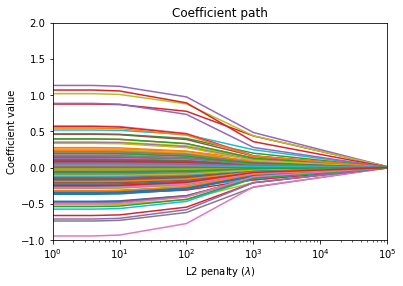

In [22]:
L2_list = [0, 4, 10, 1e2, 1e3, 1e5]
Coef_list = [coefficients_0_penalty, coefficients_4_penalty, coefficients_10_penalty, coefficients_1e2_penalty, coefficients_1e3_penalty, coefficients_1e5_penalty,]


plt.plot(L2_list, Coef_list, '-')
plt.axis([1, 1e5, -1, 2])
plt.title('Coefficient path')
plt.xlabel('L2 penalty ($\lambda$)')
plt.ylabel('Coefficient value')
plt.xscale('log')
plt.show()

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

Based on the above, we will use the same code that was used in Module 3 assignment.

In [23]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

In [24]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [25]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print("L2 penalty = %g" % key)
    print("train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.8021056598440776, validation_accuracy = 0.8083843617522374
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.8019878936335587, validation_accuracy = 0.8082901554404145
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.8019172339072473, validation_accuracy = 0.8081959491285916
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.8007866782862662, validation_accuracy = 0.8068770607630711
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.7899757401606331, validation_accuracy = 0.7957607159679698
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.7349789198483171, validation_accuracy = 0.7334903438530381
--------------------------

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

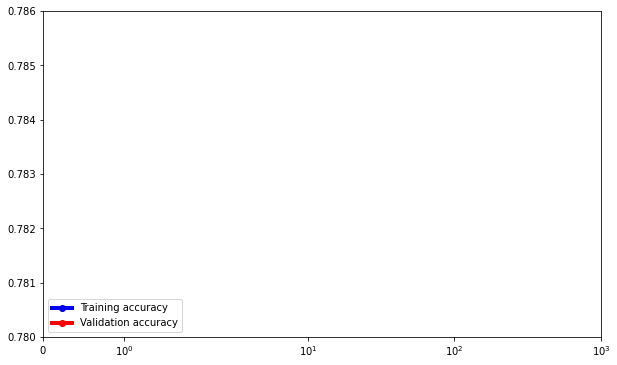

In [26]:
# Optional. Plot accuracy on training and validation sets over choice of L2 penalty.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

sorted_list = sorted(train_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'bo-', linewidth=4, label='Training accuracy')
sorted_list = sorted(validation_accuracy.items(), key=lambda x:x[0])
plt.plot([p[0] for p in sorted_list], [p[1] for p in sorted_list], 'ro-', linewidth=4, label='Validation accuracy')
plt.xscale('symlog')
plt.axis([0, 1e3, 0.78, 0.786])
plt.legend(loc='lower left')
plt.rcParams.update({'font.size': 18})
plt.tight_layout